In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tqdm.notebook import tqdm

In [ ]:
# Load model and data
model = keras.models.load_model("...../model.h5")
data = np.load(".........../data.npz")

# Convert to tensors
X_train = tf.convert_to_tensor(data["X_train"], dtype=tf.float32)
y_train = tf.convert_to_tensor(data["y_train"], dtype=tf.float32)
X_val = tf.convert_to_tensor(data["X_val"], dtype=tf.float32)
y_val = tf.convert_to_tensor(data["y_val"], dtype=tf.float32)

# Smaller validation subset
val_sample_size = 8000
X_val = X_val[:val_sample_size]
y_val = y_val[:val_sample_size]
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(64)

In [ ]:
# Training parameters
target_accuracy = 0.90
num_epochs = 3
batch_size = 1900
learning_rate = 0.001

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
loss_fn = keras.losses.BinaryCrossentropy()

In [ ]:
# Store initial weights for rewinding (skip embedding and output layers)
initial_weights = []
for layer in model.layers:
    if not isinstance(layer, keras.layers.Embedding) and layer != model.layers[-1]:  # Skip embedding and output layers
        for weight in layer.trainable_weights:
            initial_weights.append(tf.identity(weight))

In [ ]:
def get_accuracy(model, val_dataset):
    # Initialize accuracy metric
    accuracy = keras.metrics.BinaryAccuracy()
    # Iterate over validation dataset
    for x, y in val_dataset:
        # Predict and update accuracy state
        y_pred = model(x)
        accuracy.update_state(y, y_pred)
    # Return final accuracy result
    return accuracy.result().numpy()

def get_sparsity(model):
    total_params = 0
    sparse_params = 0
    # Iterate over model layers
    for layer in model.layers:
        # Check if layer is Dense or Bidirectional
        if isinstance(layer, (keras.layers.Dense, keras.layers.Bidirectional)):
            # Iterate over trainable weights
            for weight in layer.trainable_weights:
                total_params += tf.size(weight).numpy()
                sparse_params += tf.reduce_sum(tf.cast(tf.abs(weight) < 1e-8, tf.int32)).numpy()
    # Calculate and return sparsity percentage
    return 100.0 * sparse_params / total_params

def create_global_masks(model, prune_rate):
    all_weights = []
    # Collect all weights from Dense and Bidirectional layers (excluding output layer)
    for layer in model.layers:
        if isinstance(layer, (keras.layers.Dense, keras.layers.Bidirectional)) and layer != model.layers[-1]:
            for weight in layer.trainable_weights:
                all_weights.append(tf.abs(weight).numpy().flatten())
    # Concatenate all weights and calculate global threshold
    all_weights = np.concatenate(all_weights)
    global_threshold = np.percentile(all_weights, prune_rate)
    
    masks = []
    # Create masks based on global threshold
    for layer in model.layers:
        if isinstance(layer, (keras.layers.Dense, keras.layers.Bidirectional)) and layer != model.layers[-1]:
            for weight in layer.trainable_weights:
                weight_np = weight.numpy()
                mask = tf.cast(tf.abs(weight_np) >= global_threshold, tf.float32)
                masks.append(mask)
    return masks

def apply_masks(model, masks):
    idx = 0
    # Apply masks to model weights
    for layer in model.layers:
        if isinstance(layer, (keras.layers.Dense, keras.layers.Bidirectional)) and layer != model.layers[-1]:
            for weight in layer.trainable_weights:
                weight.assign(weight * masks[idx])
                idx += 1

def rewind_weights(model, initial_weights, masks):
    idx = 0
    # Rewind weights to initial values and apply masks
    for layer in model.layers:
        if isinstance(layer, (keras.layers.Dense, keras.layers.Bidirectional)) and layer != model.layers[-1]:
            for weight in layer.trainable_weights:
                # Ensure shapes match before multiplication
                if weight.shape != initial_weights[idx].shape:
                    raise ValueError(f"Shape mismatch: weight {weight.shape}, initial_weight {initial_weights[idx].shape}")
                weight.assign(initial_weights[idx] * masks[idx])
                idx += 1

def train_model_with_masks(model, dataset, epochs, masks):
    epoch_losses = []
    # Train model for specified number of epochs
    for epoch in range(epochs):
        batch_losses = []
        with tqdm(total=len(dataset), desc=f"Epoch {epoch+1}/{epochs}", leave=False) as pbar:
            for x_batch, y_batch in dataset:
                with tf.GradientTape() as tape:
                    y_pred = model(x_batch, training=True)
                    loss = loss_fn(y_batch, y_pred)
                gradients = tape.gradient(loss, model.trainable_variables)
                optimizer.apply_gradients(zip(gradients, model.trainable_variables))
                
                # Reapply masks after each update
                apply_masks(model, masks)
                
                batch_losses.append(loss.numpy())
                pbar.update(1)
        # Calculate and print epoch loss
        epoch_loss = np.mean(batch_losses)
        epoch_losses.append(epoch_loss)
        print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f}")
    return epoch_losses


In [ ]:
# Initial pruning rate and maximum pruning rate
prune_rate = 10
max_prune_rate = 98

# Evaluate initial accuracy on validation dataset
best_acc = get_accuracy(model, val_dataset)

# Initialize best masks and weights
best_masks = None
best_weights = [tf.identity(w) for w in model.trainable_weights]

In [ ]:
# Main pruning loop
while prune_rate <= max_prune_rate:
    print(f"\nPruning {prune_rate}% globally...")
    
    # Create global masks based on current prune rate
    masks = create_global_masks(model, prune_rate)
    
    # Rewind weights to initial values and apply masks
    rewind_weights(model, initial_weights, masks)
    
    # Prepare training dataset
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    train_ds = train_ds.shuffle(10000).batch(batch_size)
    
    # Train model with masks applied
    train_model_with_masks(model, train_ds, num_epochs, masks)
    
    # Evaluate accuracy on validation dataset
    acc = get_accuracy(model, val_dataset)
    sparsity = get_sparsity(model)
    print(f"Val Accuracy: {acc:.4f} | Sparsity: {sparsity:.2f}%")
    
    # Check if accuracy meets or exceeds target
    if acc >= target_accuracy:
        # Update best accuracy, masks, and weights
        best_acc = acc
        best_masks = masks
        best_weights = [tf.identity(w) for w in model.trainable_weights]
        prune_rate += 5
    else:
        print("Accuracy dropped below threshold, rolling back...")
        # Restore best weights and masks
        apply_masks(model, best_masks)
        for w, best_w in zip(model.trainable_weights, best_weights):
            w.assign(best_w)
        break


In [ ]:
print("\nFinal Results:")
print(f"Sparsity: {get_sparsity(model):.2f}%")
print(f"Validation Accuracy: {get_accuracy(model, val_dataset):.4f}")

In [ ]:
# Convert test data to tensors
X_test = tf.convert_to_tensor(data["X_test"], dtype=tf.float32)
y_test = tf.convert_to_tensor(data["y_test"], dtype=tf.float32)

# Create a dataset from the test tensors and batch it
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(64)

In [ ]:
def get_accuracy_test(model, test_dataset):
 accuracy = keras.metrics.BinaryAccuracy()
 for x, y in tqdm(test_dataset, desc='testing'):
    y_pred = model(x)
    accuracy.update_state(y, y_pred)
 return accuracy.result().numpy()

In [ ]:
test_accuracy = get_accuracy_test(model, test_dataset)
print(f"Test Accuracy: {test_accuracy:.4f}")

In [ ]:
model.save("pruned_model.h5")

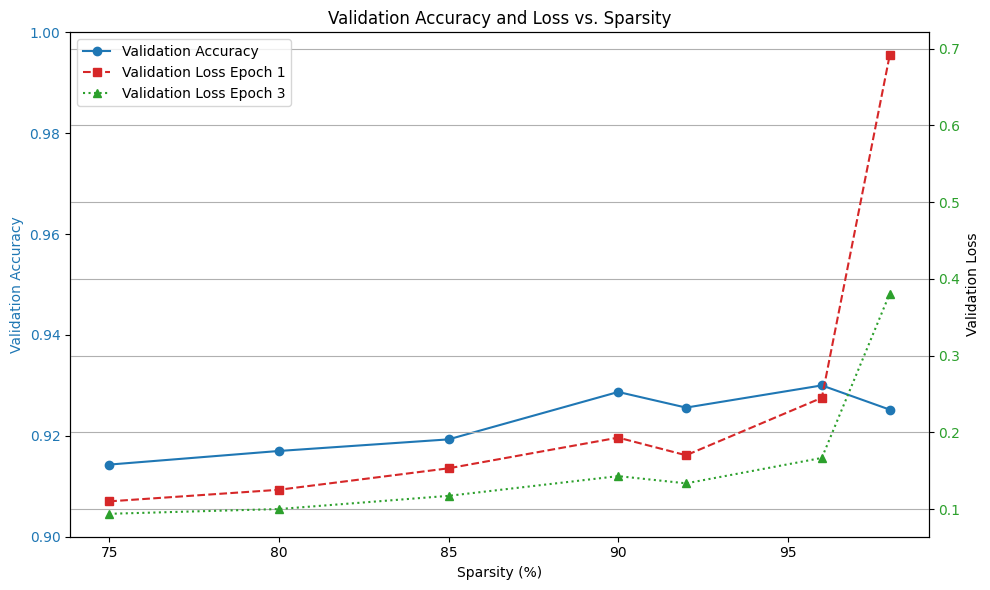

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Data from your output (manually inputting)
sparsity_values = np.array([75, 80, 85, 90, 92, 96, 98]) / 100.0
val_accuracy = np.array([0.9143, 0.9170, 0.9193, 0.9287, 0.9256, 0.9300, 0.9252])
val_loss_epoch_1 = np.array([0.1100, 0.1251, 0.1531, 0.1931, 0.1701, 0.2450, 0.6915])
val_loss_epoch_2 = np.array([0.0971, 0.1066, 0.1283, 0.1548, 0.1407, 0.1766, 0.4585])
val_loss_epoch_3 = np.array([0.0938, 0.1000, 0.1172, 0.1429, 0.1335, 0.1666, 0.3805])

# Plotting

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plotting Validation Accuracy
color = 'tab:blue'
ax1.set_xlabel('Sparsity (%)')
ax1.set_ylabel('Validation Accuracy', color=color)
ax1.plot(sparsity_values * 100, val_accuracy, marker='o', linestyle='-', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(0.9,1)

# Create a second axes that shares the same x-axis
ax2 = ax1.twinx()

# Plotting Validation Loss (Epoch 1)
color = 'tab:red'
ax2.set_ylabel('Validation Loss (Epoch 1)', color=color)
ax2.plot(sparsity_values * 100, val_loss_epoch_1, marker='s', linestyle='--', color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Plotting Validation Loss (Epoch 3)
color = 'tab:green'
ax2.plot(sparsity_values * 100, val_loss_epoch_3, marker='^', linestyle=':', color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel('Validation Loss', color='black')

# Adding a legend
lines = ax1.get_lines() + ax2.get_lines()
labels = [l.get_label() for l in lines]
plt.legend(lines, ["Validation Accuracy","Validation Loss Epoch 1","Validation Loss Epoch 3"])


plt.title('Validation Accuracy and Loss vs. Sparsity')
plt.grid(True)
plt.tight_layout()
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 12
plt.savefig('plot.png', dpi=300,bbox_inches='tight')
plt.show()